In [13]:
import pandas as pd
import scanpy as sc
from anndata import AnnData
import numpy as np
from _utils import create_anndata
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
# Day3_Markers_Dryad = pd.read_csv('Day3_Markers_Dryad.csv', delimiter=',', header=0,index_col=0)
if Path('protein_data.h5ad').exists():
    adata = sc.read_h5ad('protein_data.h5ad')
else:
    adata = create_anndata()
adata

/home/barroz/miniconda3/envs/scvi_cuda_2/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/barroz/projects/4460_Project/_utils.py:22: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.py

AnnData object with n_obs × n_vars = 5019159 × 57
    obs: 'cellid', 'donor', 'CCL5', 'Cell_Type_Common', 'Cell_Type_Sub', 'CD38', 'filename', 'region', 'x', 'y', 'Cell_Type', 'Overall_Cell_Type', 'Neighborhood', 'os_binary'
    uns: 'metadata'

In [3]:
print(adata.obs['donor'].value_counts())

donor
21_06_23_Melanoma    1529651
18_06_23_Melanoma     976931
14_06_23_Melanoma     593661
23_07_01_Melanoma     541059
05_06_23_Melanoma     472284
23_06_26_Melanoma     306068
23_07_03_Melanoma     219962
23_06_30_Melanoma     118650
23_07_06_Melanoma     102943
30_05_23_Melanoma      65639
23_06_23_Melanoma      63643
13_06_23_Melanoma      28668
Name: count, dtype: int64


In [4]:
adata_1 = adata[adata.obs['donor'] == '13_06_23_Melanoma']
adata_2 = adata[adata.obs['donor'] == '23_06_23_Melanoma']
# sc.pp.pca(adata_1)
# sc.pp.neighbors(adata_1)
# sc.pl.umap(adata_1, color='Cell_Type')
# sc.pl.pca(adata_1, color='Cell_Type')

/home/barroz/miniconda3/envs/scvi_cuda_2/lib/python3.10/site-packages/scanpy/plotting/_utils.py:487: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


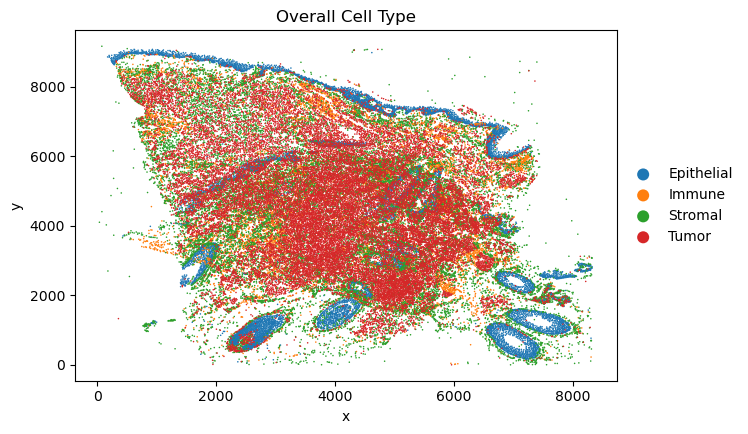

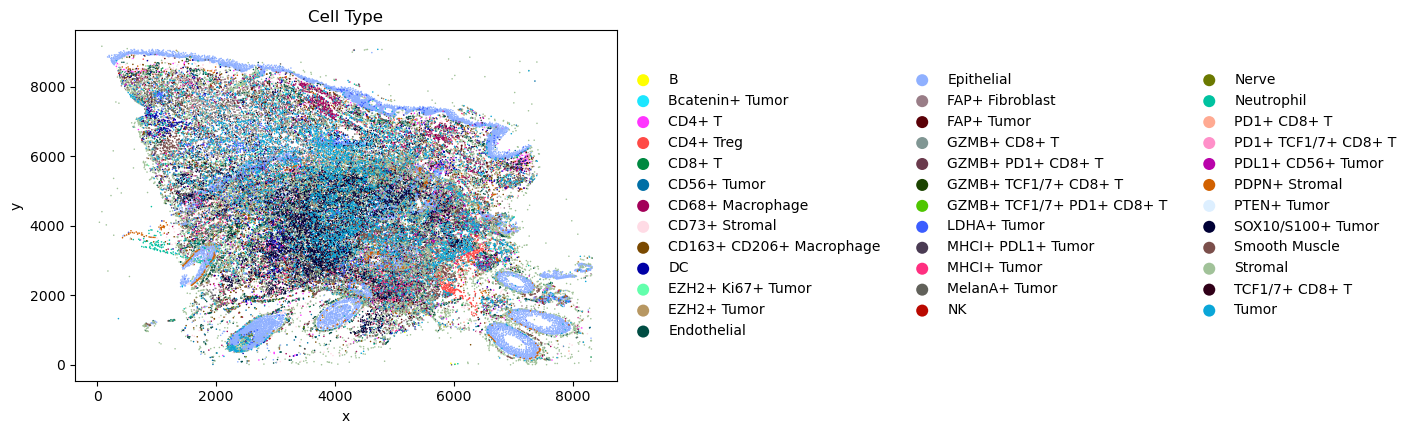

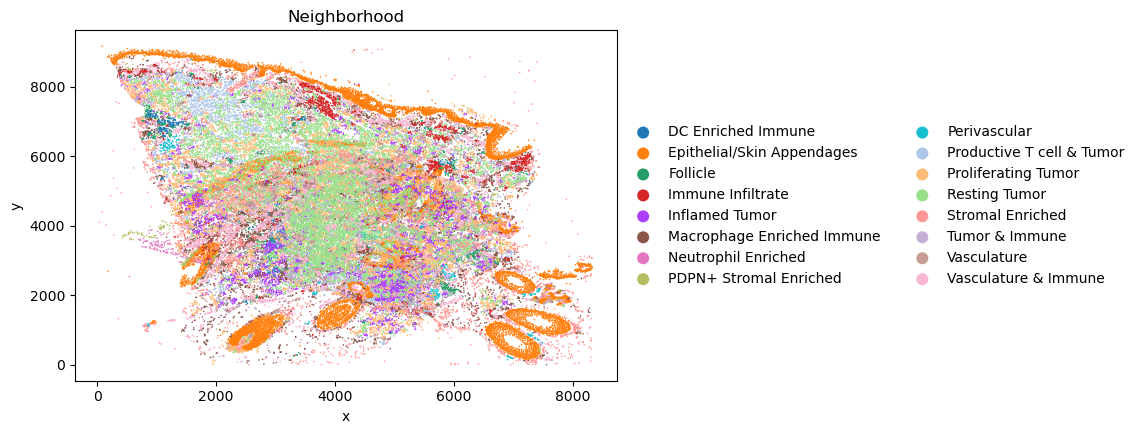

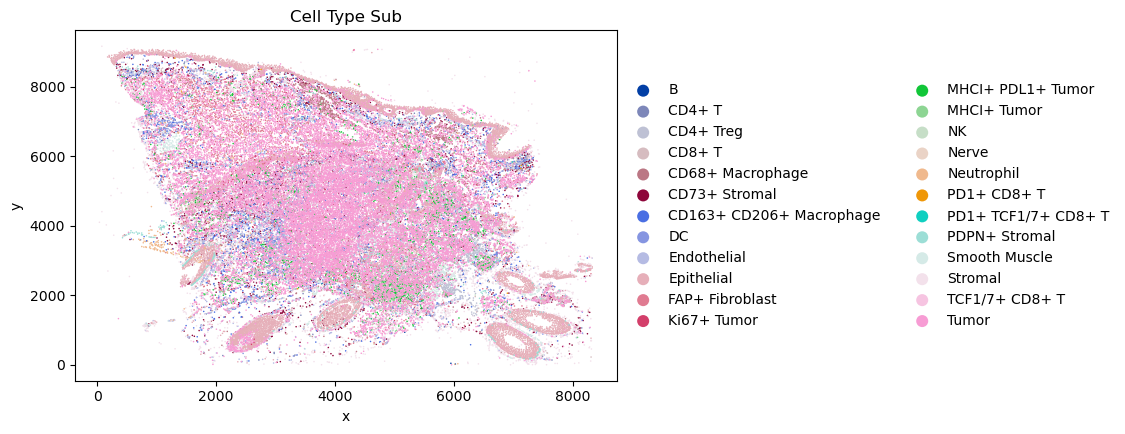

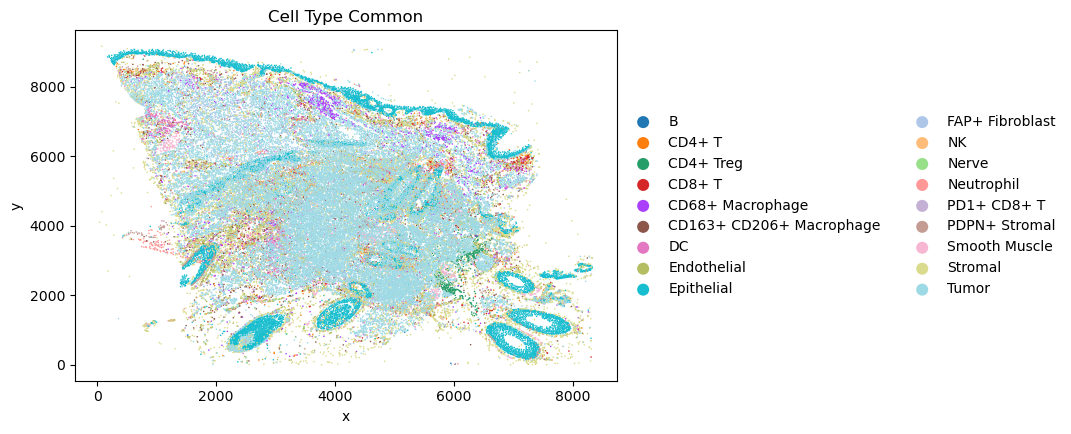

In [5]:
sc.pl.scatter(adata_2, x='x', y='y', color='Overall_Cell_Type', size=5)
sc.pl.scatter(adata_2, x='x', y='y', color='Cell_Type', size=5)
sc.pl.scatter(adata_2, x='x', y='y', color='Neighborhood', size=5)
sc.pl.scatter(adata_2, x='x', y='y', color='Cell_Type_Sub', size=5)
sc.pl.scatter(adata_2, x='x', y='y', color='Cell_Type_Common', size=5)


/home/barroz/miniconda3/envs/scvi_cuda_2/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:317: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


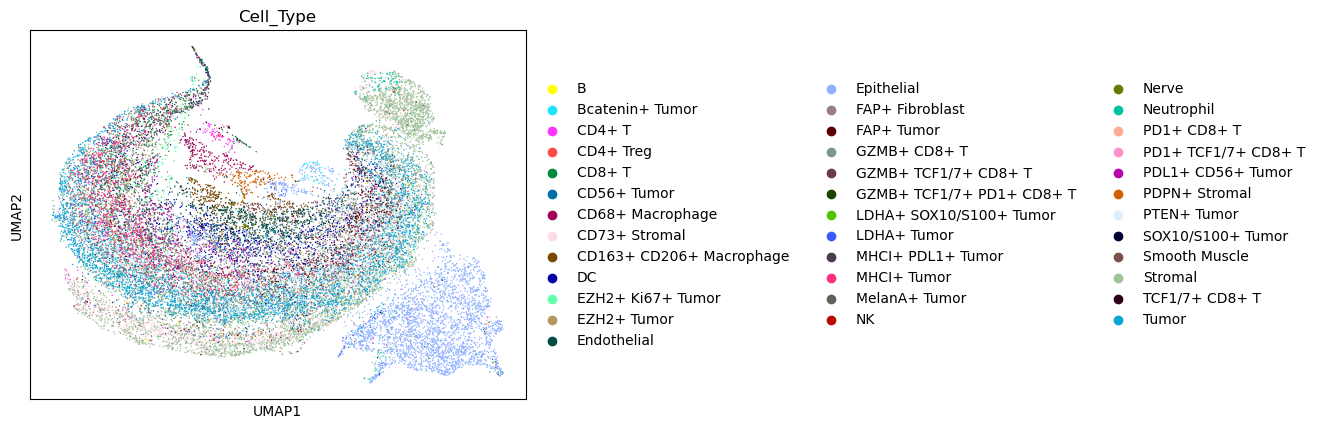

In [6]:
sc.pp.pca(adata_1)
sc.pp.neighbors(adata_1, n_neighbors=10,use_rep='X_pca')
sc.tl.umap(adata_1)
sc.pl.umap(adata_1, color='Cell_Type')

In [8]:
adata_donor

View of AnnData object with n_obs × n_vars = 1529651 × 57
    obs: 'cellid', 'donor', 'CCL5', 'Cell_Type_Common', 'Cell_Type_Sub', 'CD38', 'filename', 'region', 'x', 'y', 'Cell_Type', 'Overall_Cell_Type', 'Neighborhood', 'os_binary'
    uns: 'metadata'

In [ ]:
# take the mean of the expression of each gene for each donor
mean = []
os_binary = []
for donor in adata.obs['donor'].unique():
    num_samples_from_each_donor = 50
    for i in tqdm(range(num_samples_from_each_donor), desc=f"donor {donor}",total=num_samples_from_each_donor):
        adata_donor = adata[adata.obs['donor'] == donor].copy()
        adata_donor = adata_donor[np.random.choice(adata_donor.n_obs, 1000, replace=False)]
        adata_donor_mean = adata_donor.X.mean(axis=0)
        mean.append(adata_donor_mean)
        os_binary.append(adata_donor.obs['os_binary'].values[0]) 
    # adata_donor = adata[adata.obs['donor'] == donor]
    # adata_donor_mean = adata_donor.X.mean(axis=0)
    # # adata_donor_mean = adata_donor_mean.reshape(1, -1)
    # # mean[donor] = adata_donor_mean
    # os_binary.append(adata_donor.obs['os_binary'].values[0])
    # mean.append(adata_donor_mean)

KeyboardInterrupt: 

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(np.array(mean))
pca_embed = pca.transform(np.array(mean))
pca.explained_variance_ratio_

array([0.99709718, 0.00134769])

/tmp/ipykernel_38958/4006053079.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


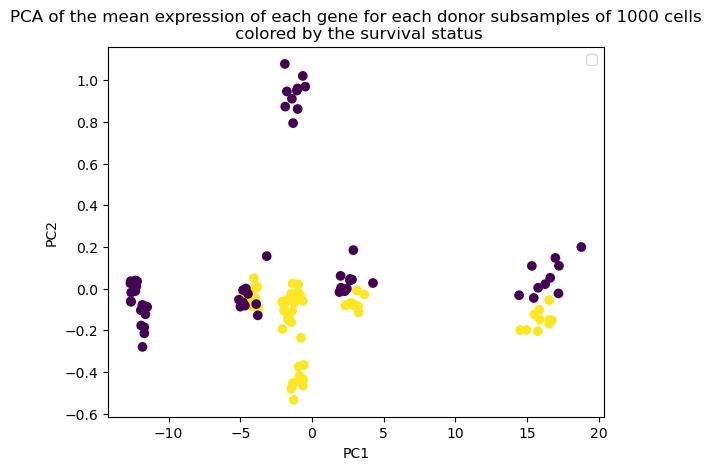

In [36]:
# plot the pca and color by the binary os
plt.scatter(pca_embed[:, 0], pca_embed[:, 1], c=pd.Categorical(os_binary).codes)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.title('PCA of the mean expression of each gene for each donor subsamples of 1000 cells\n colored by the survival status')
plt.show()


In [ ]:
# plot in 3d 
from mpl_toolkits.mplot3d import Axes3D
pca = PCA(n_components=3)
pca.fit(np.array(mean))
pca_embed = pca.transform(np.array(mean))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_embed[:, 0], pca_embed[:, 1], pca_embed[:, 2], c=pd.Categorical(os_binary).codes)
plt.show()

In [40]:
# make a linear regression to predict the survival status from the pca
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(mean, os_binary, test_size=0.3)
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
accuracy_score(y_test, y_pred)

0.7777777777777778